# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../data/')
sys.path.append('../modelling/')

In [2]:
import player_data as player
import goodness_fit
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Get data

In [3]:
file_name = 'csvs/element_gameweek_' + datetime.today().strftime('%Y-%m-%d') + '.csv'

In [4]:
try:
    element_gameweek_df = pd.read_csv(file_name)
except:
    element_gameweek_df = player.get_element_gameweek_df()
    element_gameweek_df.to_csv(file_name)

In [5]:
current_event = 32
element_types = [2, 3, 4]
threshold_minutes = 1

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
    & (element_gameweek_df['element_type'].isin(element_types))
    & (element_gameweek_df['minutes'] >= threshold_minutes)
]

In [7]:
player.add_home_categorical_variable(element_gameweek_df)

In [8]:
element_gameweek_df['row_id'] = element_gameweek_df['row_id'].rank()

In [9]:
element_gameweek_df['element_fixture_rank'] = element_gameweek_df.groupby('element')['row_id'].rank()

In [10]:
rolling_df = \
element_gameweek_df.copy().groupby('element', as_index=True)[['minutes', 'goals_scored', 'assists']]\
.rolling(38, min_periods=1).sum().reset_index()[['element', 'minutes', 'goals_scored', 'assists']]

In [11]:
rolling_df['element_fixture_rank'] = rolling_df.groupby('element')['minutes'].rank()

In [12]:
rolling_df['element_fixture_rank'] = rolling_df['element_fixture_rank'] + 1

In [13]:
element_gameweek_df =\
element_gameweek_df.join(
    rolling_df.set_index(['element', 'element_fixture_rank']),
    on=['element', 'element_fixture_rank'],
    rsuffix='_rolling')

In [14]:
element_gameweek_df['goals_scored_per_minute_rolling'] = \
element_gameweek_df['goals_scored_rolling'] / element_gameweek_df['minutes_rolling']

element_gameweek_df['assists_per_minute_rolling'] = \
element_gameweek_df['assists_rolling'] / element_gameweek_df['minutes_rolling']

element_gameweek_df['minutes_per_fixture_rolling'] = \
element_gameweek_df['minutes_rolling'] / element_gameweek_df['element_fixture_rank']

In [15]:
element_gameweek_df.head()

,row_id,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,...,safe_web_name,own_team,opposition_team,element_fixture_rank,minutes_rolling,goals_scored_rolling,assists_rolling,goals_scored_per_minute_rolling,assists_per_minute_rolling,minutes_per_fixture_rolling
80,1.0,0,92,0,0,0,11,0,6,85,...,koscielny,1,16,1.0,NaN,NaN,NaN,NaN,NaN,NaN
82,2.0,0,74,0,0,0,17,0,4,70,...,koscielny,1,3,2.0,90.0,0.0,0.0,0.0,0.0,45.0
83,3.0,0,38,0,0,0,10,0,2,36,...,koscielny,1,12,3.0,159.0,0.0,0.0,0.0,0.0,53.0
84,4.0,0,64,0,0,0,19,0,10,57,...,koscielny,1,9,4.0,204.0,0.0,0.0,0.0,0.0,51.0
85,5.0,0,89,0,0,0,17,0,2,87,...,koscielny,1,19,5.0,294.0,0.0,0.0,0.0,0.0,58.8


# Models

## Simple Poisson model

### Preparing data

In [16]:
spm_df = element_gameweek_df.copy()

In [17]:
spm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home',
    'element_fixture_rank', 'minutes_rolling',
    'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'minutes_per_fixture_rolling'
]

In [18]:
spm_df = player.remove_redundant_columns(spm_df, spm_redundant_columns)

In [19]:
spm_response_df, spm_explanatory_df = player.get_response_explanatory_dfs(spm_df, 'assists')

In [20]:
spm_explanatory_df.columns

Index(['const'], dtype='object')

In [21]:
spm_response_df.head()

80    0
82    0
83    0
84    0
85    0
Name: assists, dtype: int64

### Fitting model

In [22]:
spm_results = sm.GLM(
    spm_response_df,
    spm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [23]:
print(spm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     8160
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2667.2
Date:                Tue, 09 Apr 2019   Deviance:                       3851.1
Time:                        16:44:40   Pearson chi2:                 8.73e+03
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3414      0.036    -65.602      0.000      -2.411      -2.271


### Model fit

In [24]:
spm_results.aic

5336.441127586411

In [25]:
spm_results.bic

-69647.01735787923

In [26]:
spm_pearson_results = goodness_fit.pearson_chi_squared_test(spm_results)
spm_pearson_results

(True, 6.853729268230246e-06)

In [27]:
spm_results.resid_deviance.describe()

count    8161.000000
mean       -0.240568
std         0.643481
min        -0.438610
25%        -0.438610
50%        -0.438610
75%        -0.438610
max         3.851322
dtype: float64

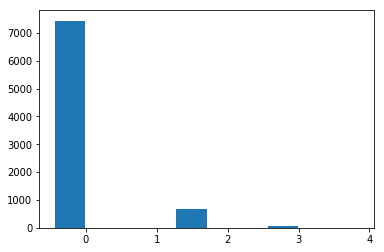

In [28]:
plt.figure()
plt.hist(spm_results.resid_deviance)
plt.show()

## Simple Poisson minutes model

### Preparing data

In [29]:
spmm_df = element_gameweek_df.copy()

In [30]:
spmm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'minutes',
    'element_fixture_rank', 'minutes_rolling',
    'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'minutes_per_fixture_rolling'
]

In [31]:
spmm_df['log_minutes'] = np.log(spmm_df['minutes'])

In [32]:
spmm_df = player.remove_redundant_columns(spmm_df, spmm_redundant_columns)

In [33]:
spmm_response_df, spmm_explanatory_df = player.get_response_explanatory_dfs(spmm_df, 'assists')

In [34]:
spmm_explanatory_df.columns

Index(['const', 'log_minutes'], dtype='object')

### Fitting model

In [35]:
spmm_results = sm.GLM(
    spmm_response_df,
    spmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [36]:
print(spmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     8159
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2625.6
Date:                Tue, 09 Apr 2019   Deviance:                       3767.8
Time:                        16:44:40   Pearson chi2:                 8.55e+03
No. Iterations:                     6                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.4008      0.280    -15.716      0.000      -4.950      -3.852
log_minutes     0.4944      0.065      7.606     

### Model fit

In [37]:
spmm_results.aic

5255.147509076489

In [38]:
spmm_results.bic

-69721.3038543997

In [39]:
spmm_pearson_results = goodness_fit.pearson_chi_squared_test(spmm_results)
spmm_pearson_results

(True, 0.001169126206877924)

In [40]:
spmm_results.resid_deviance.describe()

count    8161.000000
mean       -0.235224
std         0.637498
min        -0.476364
25%        -0.476364
50%        -0.476364
75%        -0.353750
max         3.725097
dtype: float64

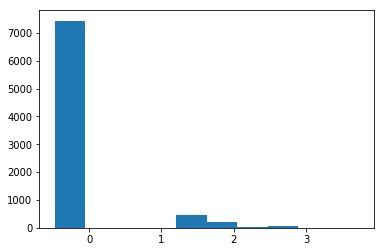

In [41]:
plt.figure()
plt.hist(spmm_results.resid_deviance)
plt.show()

## Simple Poisson exposure model

### Preparing data

In [42]:
epmm_df = element_gameweek_df.copy()

In [43]:
epmm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'minutes',
    'element_fixture_rank', 'minutes_rolling',
    'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'minutes_per_fixture_rolling'
]

In [44]:
epmm_exposure = epmm_df['minutes']

In [45]:
epmm_df = player.remove_redundant_columns(epmm_df, epmm_redundant_columns)

In [46]:
epmm_response_df, epmm_explanatory_df = player.get_response_explanatory_dfs(epmm_df, 'assists')

In [47]:
epmm_explanatory_df.columns

Index(['const'], dtype='object')

### Fitting model

In [48]:
epmm_results = sm.GLM(
    epmm_response_df,
    epmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop',
    exposure=epmm_exposure
).fit()

In [49]:
print(epmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     8160
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2648.3
Date:                Tue, 09 Apr 2019   Deviance:                       3813.3
Time:                        16:44:41   Pearson chi2:                 1.10e+04
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.5904      0.036   -184.649      0.000      -6.660      -6.520


### Model fit

In [50]:
epmm_results.aic

5298.595243230665

In [51]:
epmm_results.bic

-69684.86324223498

In [52]:
epmm_pearson_results = goodness_fit.pearson_chi_squared_test(epmm_results)
epmm_pearson_results

(True, 0.0)

In [53]:
epmm_results.resid_deviance.describe()

count    8161.000000
mean       -0.223532
std         0.646017
min        -0.497222
25%        -0.497222
50%        -0.497222
75%        -0.272340
max         3.721291
dtype: float64

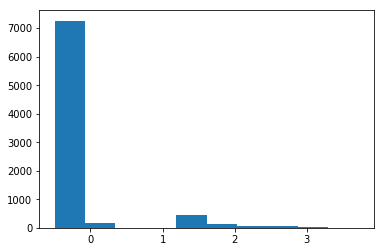

In [54]:
plt.figure()
plt.hist(epmm_results.resid_deviance)
plt.show()

## Simple Poisson teams model

### Preparing data

In [55]:
sptm_df = element_gameweek_df.copy()

In [56]:
sptm_df = player.add_categorical_variables(sptm_df, 'element_type')
sptm_df = player.add_categorical_variables(sptm_df, 'opposition_team')
sptm_df = player.add_categorical_variables(sptm_df, 'own_team')

In [57]:
sptm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team',
    'element_fixture_rank', 'minutes_rolling',
    'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'minutes_per_fixture_rolling'
]

In [58]:
sptm_df = player.remove_redundant_columns(sptm_df, sptm_redundant_columns)

In [59]:
sptm_response_df, sptm_explanatory_df = player.get_response_explanatory_dfs(sptm_df, 'assists')

In [60]:
sptm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20'],
      dtype='object')

In [61]:
sptm_response_df.head()

80    0
82    0
83    0
84    0
85    0
Name: assists, dtype: int64

### Fitting model

In [62]:
sptm_results = sm.GLM(
    sptm_response_df,
    sptm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [63]:
print(sptm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     8119
Model Family:                 Poisson   Df Model:                           41
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2551.6
Date:                Tue, 09 Apr 2019   Deviance:                       3619.8
Time:                        16:44:42   Pearson chi2:                 8.40e+03
No. Iterations:                     6                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.5393      0.234    -10.846      0.000      -2.998      -2.080
was_home               0.198

### Model fit

In [64]:
sptm_results.aic

5187.109037010568

In [65]:
sptm_results.bic

-69509.05744688684

In [66]:
sptm_pearson_results = goodness_fit.pearson_chi_squared_test(sptm_results)
sptm_pearson_results

(True, 0.01515118055247322)

In [67]:
sptm_results.resid_deviance.describe()

count    8161.000000
mean       -0.227995
std         0.625788
min        -0.868829
25%        -0.485633
50%        -0.393194
75%        -0.306295
max         3.845635
dtype: float64

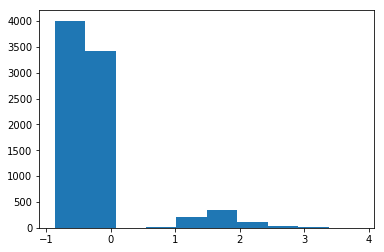

In [68]:
plt.figure()
plt.hist(sptm_results.resid_deviance)
plt.show()

## Simple Poisson teams minutes model

### Preparing data

In [69]:
sptmm_df = element_gameweek_df.copy()

In [70]:
sptmm_df = player.add_categorical_variables(sptmm_df, 'element_type')
sptmm_df = player.add_categorical_variables(sptmm_df, 'opposition_team')
sptmm_df = player.add_categorical_variables(sptmm_df, 'own_team')

In [71]:
sptmm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes',
    'element_fixture_rank', 'minutes_rolling',
    'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'minutes_per_fixture_rolling'
]

In [72]:
sptmm_df['log_minutes'] = np.log(sptmm_df['minutes'])

In [73]:
sptmm_df = player.remove_redundant_columns(sptmm_df, sptmm_redundant_columns)

In [74]:
sptmm_response_df, sptmm_explanatory_df = player.get_response_explanatory_dfs(sptmm_df, 'assists')

In [75]:
sptmm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20', 'log_minutes'],
      dtype='object')

### Fitting model

In [76]:
sptmm_results = sm.GLM(
    sptmm_response_df,
    sptmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [77]:
print(sptmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     8118
Model Family:                 Poisson   Df Model:                           42
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2488.6
Date:                Tue, 09 Apr 2019   Deviance:                       3493.8
Time:                        16:44:43   Pearson chi2:                 8.30e+03
No. Iterations:                     6                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.3312      0.388    -13.741      0.000      -6.092      -4.571
was_home               0.193

### Model fit

In [78]:
sptmm_results.aic

5063.101860124214

In [79]:
sptmm_results.bic

-69626.05750178373

In [80]:
sptmm_pearson_results = goodness_fit.pearson_chi_squared_test(sptmm_results)
sptmm_pearson_results

(False, 0.07210762979361185)

In [81]:
sptmm_results.resid_deviance.describe()

count    8161.000000
mean       -0.220616
std         0.616019
min        -0.970411
25%        -0.481391
50%        -0.373254
75%        -0.268547
max         3.792956
dtype: float64

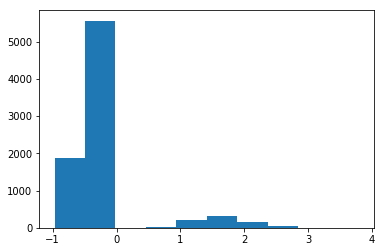

In [82]:
plt.figure()
plt.hist(sptmm_results.resid_deviance)
plt.show()

## Simple Poisson teams exposure model

### Preparing data

In [83]:
eptmm_df = element_gameweek_df.copy()

In [84]:
eptmm_df = player.add_categorical_variables(eptmm_df, 'element_type')
eptmm_df = player.add_categorical_variables(eptmm_df, 'opposition_team')
eptmm_df = player.add_categorical_variables(eptmm_df, 'own_team')

In [85]:
eptmm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes',
    'element_fixture_rank', 'minutes_rolling',
    'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'minutes_per_fixture_rolling'
]

In [86]:
eptmm_exposure = eptmm_df['minutes']

In [87]:
eptmm_df = player.remove_redundant_columns(eptmm_df, eptmm_redundant_columns)

In [88]:
eptmm_response_df, eptmm_explanatory_df = player.get_response_explanatory_dfs(eptmm_df, 'assists')

In [89]:
eptmm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20'],
      dtype='object')

### Fitting model

In [90]:
eptmm_results = sm.GLM(
    eptmm_response_df,
    eptmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop',
    exposure=eptmm_exposure
).fit()

In [91]:
print(eptmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     8119
Model Family:                 Poisson   Df Model:                           41
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2499.8
Date:                Tue, 09 Apr 2019   Deviance:                       3516.2
Time:                        16:44:44   Pearson chi2:                 9.90e+03
No. Iterations:                     6                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -6.9478      0.234    -29.673      0.000      -7.407      -6.489
was_home               0.192

### Model fit

In [92]:
eptmm_results.aic

5083.547507390469

In [93]:
eptmm_results.bic

-69612.61897650694

In [94]:
eptmm_pearson_results = goodness_fit.pearson_chi_squared_test(eptmm_results)
eptmm_pearson_results

(True, 0.0)

In [95]:
eptmm_results.resid_deviance.describe()

count    8161.000000
mean       -0.212277
std         0.621160
min        -1.025235
25%        -0.485448
50%        -0.365235
75%        -0.242721
max         3.929502
dtype: float64

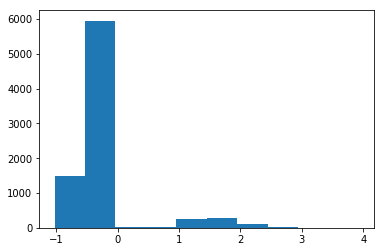

In [96]:
plt.figure()
plt.hist(eptmm_results.resid_deviance)
plt.show()

## Simple Poisson teams exposure model

### Preparing data

In [97]:
eptmmf_df = element_gameweek_df.copy()

In [98]:
eptmmf_df = player.add_categorical_variables(eptmmf_df, 'element_type')
eptmmf_df = player.add_categorical_variables(eptmmf_df, 'opposition_team')
eptmmf_df = player.add_categorical_variables(eptmmf_df, 'own_team')

In [99]:
eptmmf_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes',
    'element_fixture_rank', 'minutes_rolling',
    'goals_scored_rolling', 'assists_rolling'
]

In [100]:
eptmmf_exposure = eptmmf_df['minutes']

In [101]:
eptmmf_df = player.remove_redundant_columns(eptmmf_df, eptmmf_redundant_columns)

In [102]:
eptmmf_response_df, eptmmf_explanatory_df = player.get_response_explanatory_dfs(eptmmf_df, 'assists')

In [103]:
eptmmf_explanatory_df.columns

Index(['const', 'was_home', 'goals_scored_per_minute_rolling',
       'assists_per_minute_rolling', 'minutes_per_fixture_rolling',
       'element_type_3', 'element_type_4', 'opposition_team_2',
       'opposition_team_3', 'opposition_team_4', 'opposition_team_5',
       'opposition_team_6', 'opposition_team_7', 'opposition_team_8',
       'opposition_team_9', 'opposition_team_10', 'opposition_team_11',
       'opposition_team_12', 'opposition_team_13', 'opposition_team_14',
       'opposition_team_15', 'opposition_team_16', 'opposition_team_17',
       'opposition_team_18', 'opposition_team_19', 'opposition_team_20',
       'own_team_2', 'own_team_3', 'own_team_4', 'own_team_5', 'own_team_6',
       'own_team_7', 'own_team_8', 'own_team_9', 'own_team_10', 'own_team_11',
       'own_team_12', 'own_team_13', 'own_team_14', 'own_team_15',
       'own_team_16', 'own_team_17', 'own_team_18', 'own_team_19',
       'own_team_20'],
      dtype='object')

### Fitting model

In [104]:
eptmmf_results = sm.GLM(
    eptmmf_response_df,
    eptmmf_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop',
    exposure=eptmmf_exposure
).fit()

In [105]:
print(eptmmf_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 7702
Model:                            GLM   Df Residuals:                     7657
Model Family:                 Poisson   Df Model:                           44
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2377.3
Date:                Tue, 09 Apr 2019   Deviance:                       3330.5
Time:                        16:44:45   Pearson chi2:                 9.12e+03
No. Iterations:                     8                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -6.8384      0.281    -24.355      0.000      -7.389  

### Model fit

In [106]:
eptmmf_results.aic

4844.658215989744

In [107]:
eptmmf_results.bic

-65193.752226297394

In [108]:
eptmmf_pearson_results = goodness_fit.pearson_chi_squared_test(eptmmf_results)
eptmmf_pearson_results

(True, 0.0)

In [109]:
eptmmf_results.resid_deviance.describe()

count    7702.000000
mean       -0.214379
std         0.621705
min        -1.802767
25%        -0.486658
50%        -0.367646
75%        -0.253498
max         3.875687
dtype: float64

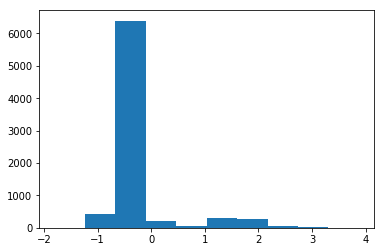

In [110]:
plt.figure()
plt.hist(eptmmf_results.resid_deviance)
plt.show()

## Simple Poisson player model

### Preparing data

In [111]:
sppm_df = element_gameweek_df.copy()

In [112]:
sppm_df = player.add_categorical_variables(sppm_df, 'opposition_team')
sppm_df = player.add_categorical_variables(sppm_df, 'element')

In [113]:
sppm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team',
    'element_fixture_rank', 'minutes_rolling',
    'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'minutes_per_fixture_rolling'
]

In [114]:
sppm_df = player.remove_redundant_columns(sppm_df, sppm_redundant_columns)

In [115]:
sppm_response_df, sppm_explanatory_df = player.get_response_explanatory_dfs(sppm_df, 'assists')

In [116]:
sppm_explanatory_df.columns

Index(['const', 'was_home', 'opposition_team_2', 'opposition_team_3',
       'opposition_team_4', 'opposition_team_5', 'opposition_team_6',
       'opposition_team_7', 'opposition_team_8', 'opposition_team_9',
       ...
       'element_592', 'element_593', 'element_594', 'element_599',
       'element_601', 'element_602', 'element_603', 'element_605',
       'element_607', 'element_608'],
      dtype='object', length=479)

### Fitting model

In [117]:
sppm_results = sm.GLM(
    sppm_response_df,
    sppm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [118]:
print(sppm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     7682
Model Family:                 Poisson   Df Model:                          478
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2195.4
Date:                Tue, 09 Apr 2019   Deviance:                       2907.4
Time:                        16:45:02   Pearson chi2:                 5.65e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -28.1789   2.05e+05     -0.000      1.000   -4.02e+05    4.02e+05
was_home               0.197

### Model fit

In [119]:
sppm_results.aic

5348.766395808333

In [120]:
sppm_results.bic

-66285.28777869102

In [121]:
sppm_pearson_results = goodness_fit.pearson_chi_squared_test(sppm_results)
sppm_pearson_results

(False, 1.0)

In [122]:
sppm_results.resid_deviance.describe()

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:340: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2 * (endog * np.log(endog_mu) - (endog - mu))) / scale)


count    8160.000000
mean       -0.165964
std         0.573409
min        -1.322024
25%        -0.484546
50%        -0.300790
75%        -0.000001
max         2.984467
dtype: float64

/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


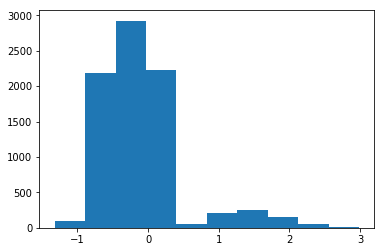

In [123]:
plt.figure()
plt.hist(sppm_results.resid_deviance)
plt.show()

## Simple Poisson player minutes model

### Preparing data

In [124]:
sppmm_df = element_gameweek_df.copy()

In [125]:
sppmm_df = player.add_categorical_variables(sppmm_df, 'opposition_team')
sppmm_df = player.add_categorical_variables(sppmm_df, 'element')

In [126]:
sppmm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes',
    'element_fixture_rank', 'minutes_rolling',
    'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'minutes_per_fixture_rolling'
]

In [127]:
sppmm_df['log_minutes'] = np.log(sppmm_df['minutes'])

In [128]:
sppmm_df = player.remove_redundant_columns(sppmm_df, sppmm_redundant_columns)

In [129]:
sppmm_response_df, sppmm_explanatory_df = player.get_response_explanatory_dfs(sppmm_df, 'assists')

In [130]:
sppmm_explanatory_df.columns

Index(['const', 'was_home', 'opposition_team_2', 'opposition_team_3',
       'opposition_team_4', 'opposition_team_5', 'opposition_team_6',
       'opposition_team_7', 'opposition_team_8', 'opposition_team_9',
       ...
       'element_593', 'element_594', 'element_599', 'element_601',
       'element_602', 'element_603', 'element_605', 'element_607',
       'element_608', 'log_minutes'],
      dtype='object', length=480)

### Fitting model

In [131]:
sppmm_results = sm.GLM(
    sppmm_response_df,
    sppmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [132]:
print(sppmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     7681
Model Family:                 Poisson   Df Model:                          479
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2158.2
Date:                Tue, 09 Apr 2019   Deviance:                       2833.1
Time:                        16:45:18   Pearson chi2:                 5.64e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -30.8171   2.03e+05     -0.000      1.000   -3.99e+05    3.99e+05
was_home               0.190

### Model fit

In [133]:
sppmm_results.aic

5276.432960085958

In [134]:
sppmm_results.bic

-66350.61409242392

In [135]:
sppmm_pearson_results = goodness_fit.pearson_chi_squared_test(sppmm_results)
sppmm_pearson_results

(False, 1.0)

In [136]:
sppmm_results.resid_deviance.describe()

count    8161.000000
mean       -0.162375
std         0.566413
min        -1.500447
25%        -0.474065
50%        -0.286202
75%        -0.000001
max         3.199662
dtype: float64

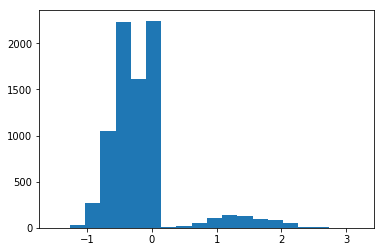

In [137]:
plt.figure()
plt.hist(sppmm_results.resid_deviance, bins=20)
plt.show()

## Simple Poisson player exposure model

### Preparing data

In [138]:
eppmm_df = element_gameweek_df.copy()

In [139]:
eppmm_df = player.add_categorical_variables(eppmm_df, 'opposition_team')
eppmm_df = player.add_categorical_variables(eppmm_df, 'element')

In [140]:
eppmm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes',
    'element_fixture_rank', 'minutes_rolling',
    'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'minutes_per_fixture_rolling'
]

In [141]:
eppmm_exposure = eppmm_df['minutes']

In [142]:
eppmm_df = player.remove_redundant_columns(eppmm_df, eppmm_redundant_columns)

In [143]:
eppmm_response_df, eppmm_explanatory_df = player.get_response_explanatory_dfs(eppmm_df, 'assists')

In [144]:
eppmm_explanatory_df.columns

Index(['const', 'was_home', 'opposition_team_2', 'opposition_team_3',
       'opposition_team_4', 'opposition_team_5', 'opposition_team_6',
       'opposition_team_7', 'opposition_team_8', 'opposition_team_9',
       ...
       'element_592', 'element_593', 'element_594', 'element_599',
       'element_601', 'element_602', 'element_603', 'element_605',
       'element_607', 'element_608'],
      dtype='object', length=479)

### Fitting model

In [145]:
eppmm_results = sm.GLM(
    eppmm_response_df,
    eppmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop',
    exposure=eppmm_exposure
).fit()

In [146]:
print(eppmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     7682
Model Family:                 Poisson   Df Model:                          478
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2168.1
Date:                Tue, 09 Apr 2019   Deviance:                       2852.9
Time:                        16:45:36   Pearson chi2:                 6.62e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -32.5093   1.99e+05     -0.000      1.000   -3.91e+05    3.91e+05
was_home               0.192

### Model fit

In [147]:
eppmm_results.aic

5294.198368296822

In [148]:
eppmm_results.bic

-66339.85580620253

In [149]:
eppmm_pearson_results = goodness_fit.pearson_chi_squared_test(eppmm_results)
eppmm_pearson_results

(False, 1.0)

In [150]:
eppmm_results.resid_deviance.describe()

count    8160.000000
mean       -0.156684
std         0.570179
min        -1.561685
25%        -0.470480
50%        -0.272196
75%        -0.000001
max         3.496394
dtype: float64

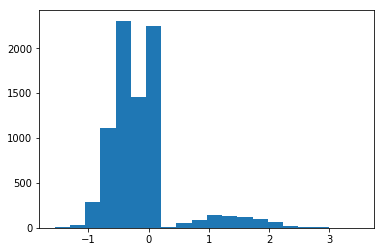

In [151]:
plt.figure()
plt.hist(eppmm_results.resid_deviance, bins=20)
plt.show()

# Model comparison

In [152]:
aic = {
    'Simple Poisson': spm_results.aic,
    'Poisson teams': sptm_results.aic,
    'Poisson players': sppm_results.aic,
    
    'Simple Poisson minutes': spmm_results.aic,
    'Simple Poisson exposure': epmm_results.aic,
    'Poisson teams minutes': sptmm_results.aic,
    'Poisson teams exposure': eptmm_results.aic,
    'Poisson teams exposure form': eptmmf_results.aic,
    'Poisson players minutes': sppmm_results.aic,
    'Poisson players exposure': eppmm_results.aic,
    }
aic

{'Simple Poisson': 5336.441127586411,
 'Poisson teams': 5187.109037010568,
 'Poisson players': 5348.766395808333,
 'Simple Poisson minutes': 5255.147509076489,
 'Simple Poisson exposure': 5298.595243230665,
 'Poisson teams minutes': 5063.101860124214,
 'Poisson teams exposure': 5083.547507390469,
 'Poisson teams exposure form': 4844.658215989744,
 'Poisson players minutes': 5276.432960085958,
 'Poisson players exposure': 5294.198368296822}

In [153]:
bic = {
    'Simple Poisson': spm_results.bic,
    'Poisson teams': sptm_results.bic,
    'Poisson players': sppm_results.bic,
    
    'Simple Poisson minutes': spmm_results.bic,
    'Simple Poisson exposure': epmm_results.bic,
    'Poisson teams minutes': sptmm_results.bic,
    'Poisson teams exposure': eptmm_results.bic,
    'Poisson teams exposure form': eptmmf_results.bic,
    'Poisson players minutes': sppmm_results.bic,
    'Poisson players exposure': eppmm_results.bic,
    }
bic

{'Simple Poisson': -69647.01735787923,
 'Poisson teams': -69509.05744688684,
 'Poisson players': -66285.28777869102,
 'Simple Poisson minutes': -69721.3038543997,
 'Simple Poisson exposure': -69684.86324223498,
 'Poisson teams minutes': -69626.05750178373,
 'Poisson teams exposure': -69612.61897650694,
 'Poisson teams exposure form': -65193.752226297394,
 'Poisson players minutes': -66350.61409242392,
 'Poisson players exposure': -66339.85580620253}

In [155]:
comp_df = pd.DataFrame([
    aic,
    bic
]).T
comp_df.columns = [
    'AIC',
    'BIC'
]
comp_df.astype('int64')

,AIC,BIC
Poisson players,5348,-66285
Poisson players exposure,5294,-66339
Poisson players minutes,5276,-66350
Poisson teams,5187,-69509
Poisson teams exposure,5083,-69612
Poisson teams exposure form,4844,-65193
Poisson teams minutes,5063,-69626
Simple Poisson,5336,-69647
Simple Poisson exposure,5298,-69684
Simple Poisson minutes,5255,-69721
